In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load dataset
file_path = "/Users/prernapawar/Downloads/Stocks data.csv"
df = pd.read_csv(file_path)

In [4]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sorting data by date
df = df.sort_values(by='Date')

# Handling missing values: Fill using forward fill
df.fillna(method='ffill', inplace=True)

# Display the first few rows after cleaning
df.head()

/var/folders/nt/355s2jrs1fj3tgr8dxn7fqq40000gn/T/ipykernel_30561/1334695536.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,Index,Date,Open,High,Low,Close,Adj Close,Volume
92450,N225,1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0.0
92451,N225,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0
92452,N225,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0
92453,N225,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0
92454,N225,1965-01-11,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0


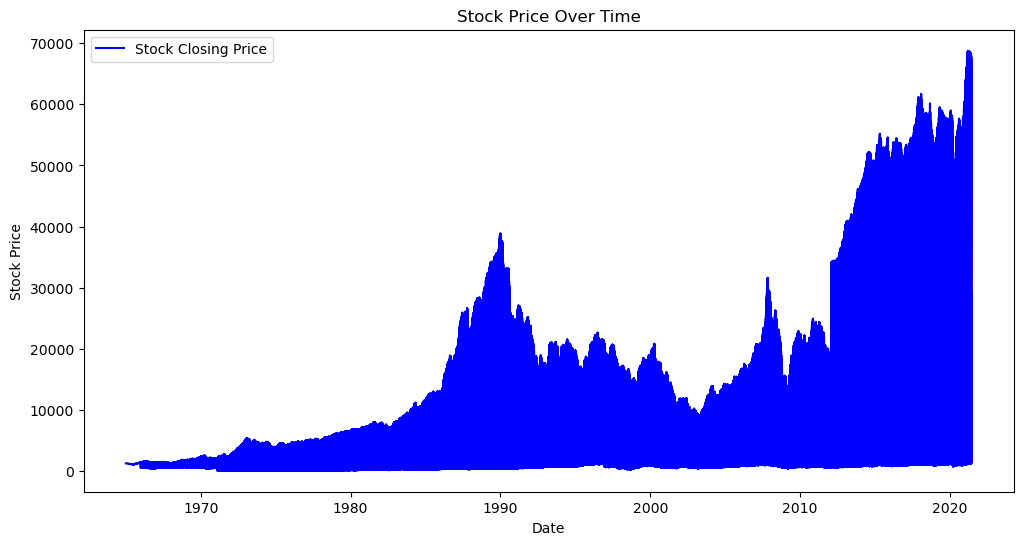

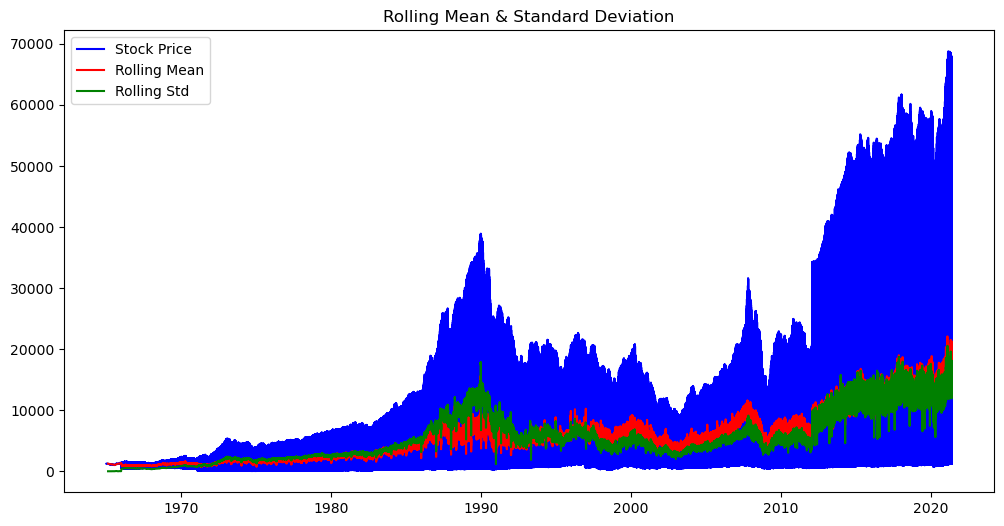

In [5]:
# Plot stock closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Stock Closing Price", color='b')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()

# Rolling Mean & Standard Deviation
df['Rolling_Mean'] = df['Close'].rolling(window=30).mean()
df['Rolling_Std'] = df['Close'].rolling(window=30).std()

# Plot rolling mean & std
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Stock Price", color='blue')
plt.plot(df['Date'], df['Rolling_Mean'], label="Rolling Mean", color='red')
plt.plot(df['Date'], df['Rolling_Std'], label="Rolling Std", color='green')
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(df['Close'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] > 0.05:
    print("Data is non-stationary")
else:
    print("Data is stationary")


ADF Statistic: -3.5617169785479077
p-value: 0.006536534327612465
Data is stationary


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Create Lag Features
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_7'] = df['Close'].shift(7)

# Moving Averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Drop NaN values caused by shifts
df.dropna(inplace=True)

# Normalize data
scaler = MinMaxScaler()
df[['Close', 'Close_Lag_1', 'Close_Lag_7', 'MA_10', 'MA_30']] = scaler.fit_transform(df[['Close', 'Close_Lag_1', 'Close_Lag_7', 'MA_10', 'MA_30']])

df.head()


,Index,Date,Open,High,Low,Close,Adj Close,Volume,Rolling_Mean,Rolling_Std,Close_Lag_1,Close_Lag_7,MA_10,MA_30
92479,N225,1965-02-15,1249.500000,1249.500000,1249.500000,0.017384,1249.500000,0.0,1262.558667,15.496746,0.017507,0.017560,0.033304,0.025600
92480,N225,1965-02-16,1247.010010,1247.010010,1247.010010,0.017348,1247.010010,0.0,1262.201668,15.733612,0.017384,0.017589,0.033331,0.025583
92481,N225,1965-02-17,1237.079956,1237.079956,1237.079956,0.017203,1237.079956,0.0,1261.304667,16.381880,0.017348,0.017521,0.033295,0.025541
92482,N225,1965-02-18,1241.410034,1241.410034,1241.410034,0.017266,1241.410034,0.0,1260.209334,16.582414,0.017203,0.017416,0.033230,0.025490
92483,N225,1965-02-19,1237.349976,1237.349976,1237.349976,0.017207,1237.349976,0.0,1258.573332,16.325404,0.017266,0.017371,0.033145,0.025413


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define Features & Target
X = df[['Close_Lag_1', 'Close_Lag_7', 'MA_10', 'MA_30']]
y = df['Close']

# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression MAE: {mae:.4f}")
print(f"Linear Regression RMSE: {rmse:.4f}")


Linear Regression MAE: 0.0698
Linear Regression RMSE: 0.1101


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Reshape data for LSTM (samples, time steps, features)
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Define LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile Model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
lstm_model.fit(X_train_lstm, y_train, batch_size=16, epochs=20, verbose=1)

# Predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate Model
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print(f"LSTM MAE: {mae_lstm:.4f}")
print(f"LSTM RMSE: {rmse_lstm:.4f}")


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5622/5622 ━━━━━━━━━━━━━━━━━━━━ 6s 887us/step - loss: 0.0133
Epoch 2/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 894us/step - loss: 0.0124
Epoch 3/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 924us/step - loss: 0.0127
Epoch 4/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 923us/step - loss: 0.0129
Epoch 5/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 912us/step - loss: 0.0125
Epoch 6/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 916us/step - loss: 0.0125
Epoch 7/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 930us/step - loss: 0.0125
Epoch 8/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 934us/step - loss: 0.0125
Epoch 9/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 923us/step - loss: 0.0126
Epoch 10/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 926us/step - loss: 0.0124
Epoch 11/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 929us/step - loss: 0.0125
Epoch 12/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 933us/step - loss: 0.0125
Epoch 13/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 929us/step - loss: 0.0124
Epoch 14/20
5622/5622 ━━━━━━━━━━━━━━━━━━━━ 5s 933us/step - loss: 0.0126
Epoch 15/20


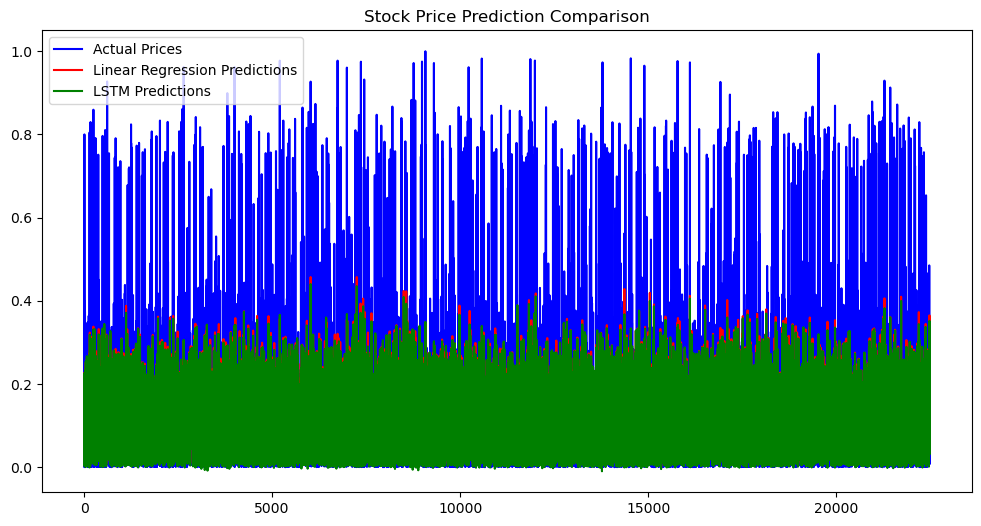

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Prices", color='blue')
plt.plot(y_pred_lr, label="Linear Regression Predictions", color='red')
plt.plot(y_pred_lstm, label="LSTM Predictions", color='green')
plt.title("Stock Price Prediction Comparison")
plt.legend()
plt.show()


In [14]:
print("Performance Comparison:")
print(f"Linear Regression -> MSE: {mae:.4f}, R² Score: {rmse:.4f}")
print(f"LSTM -> MSE: {mae_lstm:.4f}, R² Score: {rmse_lstm:.4f}")


Performance Comparison:
Linear Regression -> MSE: 0.0698, R² Score: 0.1101
LSTM -> MSE: 0.0687, R² Score: 0.1103
